## TARGET PROBABILITY
In this experiment, we would attempt to calculate the probability of a price target getting reached, within a period of time.

### PARAMETERS
- Forecast time range - `t_delta`

#### PROCEDURE

- Calculate the target price
- Calculate the ATR with a period of `t-delta`
- Compute the distribution (standard deviation) of assets return, over the period of time

In [1]:
# Parameters
t_delta = 14
p_value = 0.05

In [2]:
# Import the data
import pandas as pd
from pathlib import Path
import pandas_ta as ta
import quantstats as qt #noqa
import numpy as np
import seaborn as sns #noqa
import matplotlib.pyplot as plt

aapl_path = Path.cwd().parent / 'data/aapl_h1.csv'
btc_path = Path.cwd().parent / 'data/btcusdt_h1.parquet'

In [3]:
# Functions
def get_distribution(data, title):
    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    
    print("Mean : ", mean)
    print("Standard Deviation : ", std)
    
    # Plot the distribution
    plt.hist(data, bins=30, color='lightblue', edgecolor='black') 

    # Add vertical line at the median using plt.axvline
    plt.axvline(x=mean, color='blue', linestyle='--', label='Mean')
    plt.axvline(x=median, color='red', linestyle='--', label='Median')

    # Customization
    plt.title(f"Distribution of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()  # Show the label

    plt.show() 

In [4]:
# Prepare Data
# raw_data = pd.read_parquet(btc_path)
# raw_data.reset_index(names=['datetime'], inplace=True)

raw_data = pd.read_csv(aapl_path)
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
raw_data.head(3)

,datetime,open,high,low,close,volume
0,1998-01-02 16:00:00,0.12,0.12,0.12,0.12,14512400
1,1998-01-02 17:00:00,0.12,0.13,0.12,0.12,52987312
2,1998-01-02 18:00:00,0.12,0.13,0.12,0.13,23746800


In [8]:
# Filter the date range
data = raw_data[(raw_data['datetime'].dt.year >= 2010) & (raw_data['datetime'].dt.year <= 2023)]
data = data.reset_index(drop=True)

# Compute Returns
returns = data['close'].diff().fillna(0)
# returns = data['close'].pct_change().fillna(0)

# Handle Outlier in Returns : Replace with the mean
mean_return = np.mean(returns)
returns.loc[returns.abs() > np.percentile(returns.abs(), 99)] = mean_return # Replace outliers: returns greater than 99th percentile

# Feature Engineering
data['next_returns'] = returns.shift(-1)
data['atr'] = ta.atr(data['high'], data['low'], data['close'], t_delta)

data['max_runup'] = data['next_returns'].rolling(t_delta).apply(lambda x : max(np.cumsum(x))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars
data['max_rundown'] = data['next_returns'].rolling(t_delta).apply(lambda x : min(np.cumsum(x))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars

data['runup_atr_ratio'] = data['max_runup'] / data['atr']
data['rundown_atr_ratio'] = data['max_rundown'] / data['atr']

# data['lookahead_return'] = data['next_returns'].rolling(t_delta).sum().shift(-t_delta) # Gets the return from the next [lookback] bars

# data['max_drawdown'] = data['next_returns'].rolling(t_delta).apply(lambda x : qt.stats.max_drawdown(x)).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars
# data['max_runup'] = data['next_returns'].rolling(t_delta).apply(lambda x : max(np.cumsum(x))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars

# # Calculate the distributions
# data['returns_atr_ratio'] = data['lookahead_return'] / data['atr_ratio'] # Total returns over the lookahead period
# data['rar_smooth'] = ta.ema(data['returns_atr_ratio'], 50) # Smoothen the distribution

# data['dd_atr_ratio'] = data['max_drawdown'] / data['atr_ratio']
# data['ru_atr_ratio'] = data['max_runup'] / data['atr_ratio']

# Drop NaNs
data = data.dropna(axis=0)

# 
full_data = data.copy()
data = data.drop(['open', 'high', 'low', 'volume', 'datetime'], axis=1)

# Print Sample
display(data.shape)
data.head(10)

(25223, 7)

,close,next_returns,atr,max_runup,max_rundown,runup_atr_ratio,rundown_atr_ratio
14,7.65,0.01,0.037857,-0.04,-0.18,-1.056604,-4.754717
15,7.66,-0.04,0.037296,-0.03,-0.14,-0.804378,-3.753762
16,7.62,-0.03,0.039632,-0.02,-0.11,-0.504644,-2.775540
17,7.59,-0.04,0.040373,0.02,-0.07,0.495387,-1.733853
18,7.55,0.02,0.042489,-0.01,-0.09,-0.235356,-2.118208
19,7.57,-0.04,0.044454,0.03,-0.05,0.674857,-1.124762
20,7.53,-0.03,0.045564,0.06,-0.02,1.316821,-0.438940
21,7.50,0.03,0.048738,0.03,-0.05,0.615533,-1.025888
22,7.53,-0.01,0.050971,0.04,-0.04,0.784756,-0.784756
23,7.52,-0.01,0.050188,0.05,-0.03,0.996262,-0.597757


Mean :  -1.5454325711175216
Standard Deviation :  2.0717867780648263


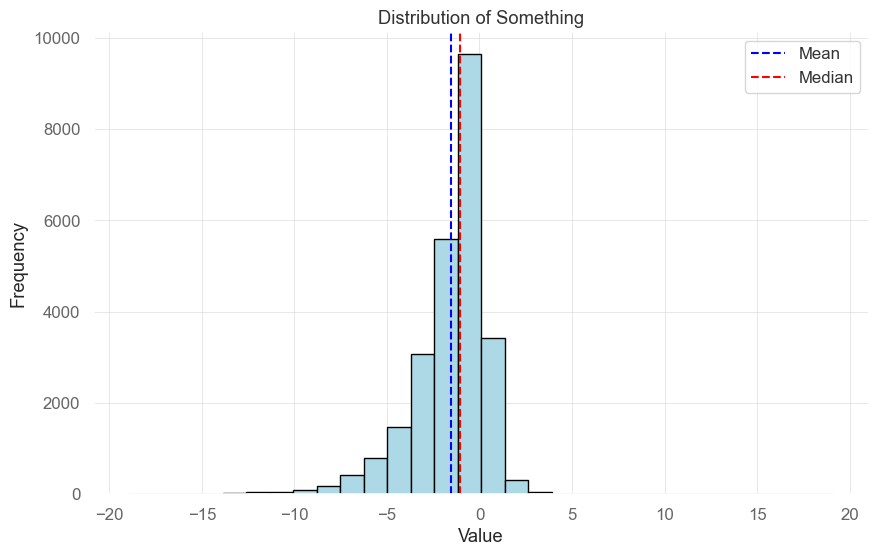

In [13]:
get_distribution(data['rundown_atr_ratio'], 'Something')

In [14]:
np.percentile(data['max_runup'], 1)

-0.7599999999999965